# Creating domains via logic operations: Example 4

We now consider the same problem as before, but add more complexity to the domain to get closer to our goal of simulating the heat in a drilling process. Therefore, we cut out a rectangular part of our domain:

\begin{align*}
    \partial_t u -0.1\Delta u &= 0.0 &&\text{ in } [0, 2] \times \Omega &\\
    u(\cdot, 0) &= 0 &&\text{ in } \Omega &\\
    u(x, t) &= 0 , &&\text{ for } x_2=0, \\
    \kappa \nabla u(x, t)\cdot n &= 0,\\
    \kappa \nabla u(x, t)\cdot n &= f,
\end{align*}
with $\Omega(t) = ([0, 1] \times [0, 1]) \setminus D$, where $D = [0.2, 0.4] \times [0.6, 1.0]$ and the boundary parts are given by:
\begin{align*}
    \Gamma_H &=  [0.2, 0.4] \times \{0.6\}, \\
    \Gamma_N &=  \partial ([0, 1] \times [0, 1]) \setminus (\{x_2=0\} \cup \Gamma_H).
\end{align*}

In [ ]:
import pathlib
import os
gpu_device = str(int(str(pathlib.Path().resolve())[-2:]) % 8)
os.environ["CUDA_VISIBLE_DEVICES"]= gpu_device

As before, we start by implementing the *Spaces* that appear in the problem:

In [17]:
import torchphysics as tp

### TODO: implement all spaces
X = tp.spaces.R2('x')
U = tp.spaces.R1('u')
T = tp.spaces.R1('t')

We now define the basic parameters and functions that appear in our problem.

In [18]:
import torch
import torchphysics as tp
import pytorch_lightning as pl
import math

# Here all parameters are defined, please use these below.
t_min, t_max = 0.0, 2.0
prod_speed = 1.0 # speed of heating

size_x, size_y = 1.0, 1.0
x_start, x_end = 0.2, 0.4
drill_height = 0.6

kappa = 0.1 # heat diffusion

# Function for heat source
def f(x, t):
    heat_source = 80 * (x[:, :1] - x_start) * (x_end - x[:, :1])
    heat_source *= (1.0 - torch.exp(-prod_speed*t))
    return heat_source

Now we define our domain. The space domain is already completed, here you have to create the time interval and the Cartesian product of both.

In [19]:
base_domain = tp.domains.Parallelogram(X, [0,0], [size_x,0], [0,size_y])
drill = tp.domains.Parallelogram(X, [x_start, drill_height], [x_end, drill_height], [x_start, 1])

### TODO: create the PDE domain by computing the difference of the previously defined domains
omega = base_domain - drill

I_t = tp.domains.Interval(T, t_min, t_max)
product_domain = I_t * omega

Please also try other shapes and shape operations such as union or intersection to create more complex domains and visualize them by sampling points on the domain and its boundary:

In [ ]:
just_for_fun_domain = ...

just_for_fun_sampler = tp.samplers.RandomUniformSampler(just_for_fun_domain.boundary, 100)

tp.utils.scatter(X, just_for_fun_sampler)

This time, when creating samplers, we make them partially static to obtain a faster optimization.

In [ ]:
# To evaluate the PDE condition (in the inner part of the domain) as well as the initial condition, we create similar samplers to before:
inner_sampler = tp.samplers.RandomUniformSampler(product_domain, n_points=25000).make_static(resample_interval=200)
# we choose to use .make_static(resample_interval=200) to resample new random points every 200 iterations.
# this will speed up the training process when compared to the standard resampling in every iteration
initial_sampler = tp.samplers.RandomUniformSampler(I_t.boundary_left*omega, n_points=5000).make_static(resample_interval=200)


# We again have 3 different boundary conditions that should be satisfied.
### TODO: create a static filter-based sampler for the Dirichlet condition at the bottom of the domain.
# Every 200 iterations, sample 8000 new points on this part of the boundary.
def bottom_filter(x):
    return x[..., 1] == 0
bottom_sampler = tp.samplers.RandomUniformSampler(omega.boundary*I_t, 8000, filter_fn=bottom_filter).make_static(resample_interval=200)


### TODO: For the inflow sampler, we decide to filter from the boundary of a drill domain. As a result, less sampled points are thrown away by the filtering.
# Implement the sampler. Every 200 iterations, sample 1000 new points on this part of the boundary.

def inflow_filter(x):
    return (x[..., 1] == drill_height) & (x[..., 0] > x_start) & (x[..., 0] < x_end)
inflow_sampler = tp.samplers.RandomUniformSampler(drill.boundary*I_t, 1000, filter_fn=inflow_filter).make_static(resample_interval=200)

# similar to before
def isolated_filter(x):
    return ~ (bottom_filter(x) | inflow_filter(x))
isolated_sampler = tp.samplers.RandomUniformSampler(omega.boundary*I_t, 20000, filter_fn=isolated_filter).make_static(resample_interval=200)

Implement a NN, with the same architecture as in the previous exercise.

In [21]:
model = tp.models.FCN(input_space=T*X, output_space=U, hidden=(30,30,30))

Now, we have to transform out mathematical conditions given by our problem into corresponding training conditions.

First, we handle the PDE itself, similar to before.

In [22]:
def pde_residual(u, x, t):
    return tp.utils.grad(u, t) - kappa*tp.utils.laplacian(u, x)

### TODO: recall the ingredients that you need in a PINNCondition and implement it.
pde_cond = tp.conditions.PINNCondition(model, inner_sampler, pde_residual)

We now also need the initial condition.

In [23]:
# Implement the residual for the initial condition:
def initial_residual(u):
    return u

initial_cond = tp.conditions.PINNCondition(model, initial_sampler, initial_residual, weight=1.)

The boundary conditions did not change when compared to the previous exercise.

In [24]:
def bottom_residual(u):
    return u

bottom_cond = tp.conditions.PINNCondition(model, bottom_sampler, bottom_residual, weight=1.)


def inflow_residual(u, x, t):
    normal_vectors = omega.boundary.normal(x)
    normal_derivative = tp.utils.normal_derivative(u, normal_vectors, x)
    return kappa * normal_derivative - f(x, t)

inflow_cond = tp.conditions.PINNCondition(model, inflow_sampler, inflow_residual, weight=1.)


def isolated_residual(u, x, t):
    normal_vectors = omega.boundary.normal(x)
    normal_derivative = tp.utils.normal_derivative(u, normal_vectors, x)
    return kappa * normal_derivative

isolated_cond = tp.conditions.PINNCondition(model, isolated_sampler, isolated_residual, weight=50.)

Before the training we collect all conditions and choose our training procedure:

In [25]:
optim = tp.OptimizerSetting(torch.optim.Adam, lr=1e-3)
solver = tp.solver.Solver([pde_cond, initial_cond, bottom_cond, inflow_cond, isolated_cond], optimizer_setting=optim)

Start the training:

In [ ]:
import pytorch_lightning as pl
trainer = pl.Trainer(devices=1, accelerator="gpu", # use one GPU
                     max_steps=5000, # iteration number
                     benchmark=True, # faster training if input batch has constant size
                     logger=False, # to avoid logging into tensorboard
                     enable_checkpointing=False)
trainer.fit(solver)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summar

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchphysics/problem/domains/domainoperations/sampler_helper.py:49: UserWarning: Will sample random points in the created domain operation, with
                     a for loop over all input parameters, in total: 1
                     This may slow down the training.
  warnings.warn(f"""Will sample random points in the created domain operation, with


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=5000` reached.


We can plot the solution, for two different time points:

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torchphysics/problem/domains/domain2D/parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)
/usr/local/lib/python3.10/dist-packages/torchphysics/problem/domains/domainoperations/sampler_helper.py:162: UserWarning: Will sample random points in the cr

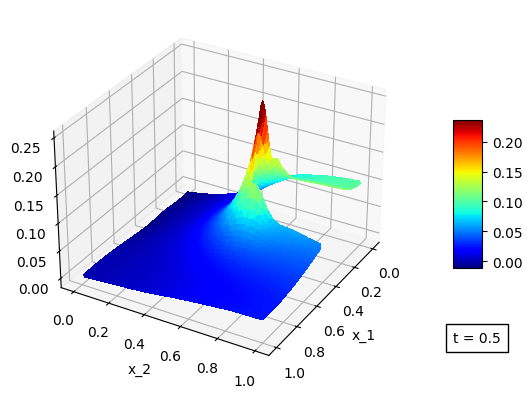

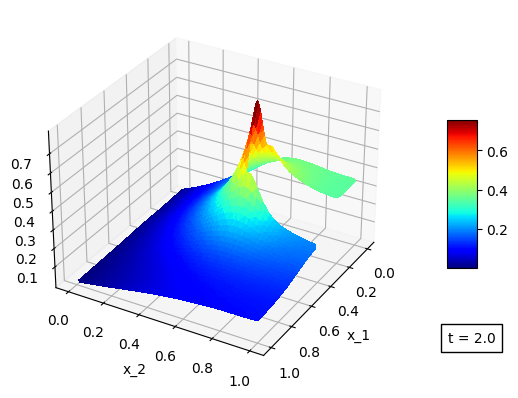

In [13]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=omega, n_points=2000, data_for_other_variables={"t": 0.5})
fig = tp.utils.plot(model, lambda u : u, plot_sampler)


plot_sampler = tp.samplers.PlotSampler(plot_domain=omega, n_points=2000, data_for_other_variables={"t": 2.0})
fig = tp.utils.plot(model, lambda u : u, plot_sampler)

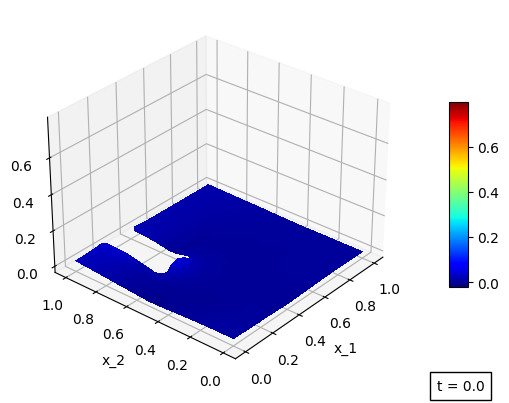

In [14]:
# We can also animate the solution over time
anim_sampler = tp.samplers.AnimationSampler(omega, I_t, 200, n_points=1000)
fig, anim = tp.utils.animate(model, lambda u: u, anim_sampler, ani_speed=10, angle=[30, 220])
anim.save('heat-eq.gif')
# On Google colab you have at the left side a tab with a folder. There you can find the gif and can watch it.